# Project 1
from Artem Opperman's course: Deep Learning for Predictive Analytics

## 0 Installing the GPU-enabled version of Tensorflow 1.13

- Artem's course uses Tensorflow 1.13
- As of 19th August 2019, Tensorflow 2.0 has been released
- Many of the functions used here from tf.contrib are deprecated and were removed/moved after Tensorflow 1.14

In [0]:
!pip install tensorflow-gpu==1.13.1

import tensorflow as tf
from IPython.display import clear_output

clear_output()

## 1 Problem statement discussion


The project is based on the dataset used by Moro et al., 2014 <sup>[[1]](http://dx.doi.org/10.1016/j.dss.2014.03.001)</sup> in their publication: _S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems_

---

The publication's abstract provides the problem statement for us: " ***...to predict the success of telemarketing calls for selling bank long-term deposits***."

---


The dataset has 20 variables (predictive features) for the target variable $y$ which is defined as the answer to the binary question: has the client subscribed a term deposit?
The dataset is based on "Bank Marketing" UCI dataset. <sup>[[2]](http://archive.ics.uci.edu/ml/datasets/Bank+Marketing)</sup>The data is enriched by the addition of five new social and economic features/attributes (national wide indicators from a ~10M population country, published by the Banco de Portugal and publicly available<sup>[[3]](https://www.bportugal.pt/estatisticasweb)</sup> online. Please note that the version of the dataset used for the project is not the same as the one used by Moro et.al. 2014. It does not include all attributes due to privacy concerns.
<br>
<br>
The original dataset actually had 150 features with bank client, product and social-economic attributes. A semi-automatic feature selection was explored in the modeling phase, performed with the data prior to July 2012 and that allowed to select a reduced set of 22 features. We are working with this reduced version essentially.
<br>
<br>

The zip file provided by Artem includes two fles:
 - `bank-additional-full.csv` with all examples, ordered by date (from May 2008 to November 2010).
 - `dataset_info.txt` which answers most of the questions relevant to descriptive analysis of the dataset.
 
 ---
***The binary classification goal, as specified by the instructor, is to predict if the client will subscribe a bank term deposit***

## 2 Downloading the dataset from Deep Learning Academy's hosted contents


In [2]:
import urllib.request

!rm -rf *.rar
download_URL = "https://www.filepicker.io/api/file/rAA6HuWARrOrIGOVzpiE"
urllib.request.urlretrieve(download_URL, "datasets.rar")

('datasets.rar', <http.client.HTTPMessage at 0x7f3bb04479e8>)

In [3]:
!ls

datasets.rar  sample_data


In [0]:
!pip install patool

import patoolib

patoolib.extract_archive("./datasets.rar", outdir = "./")
clear_output()

In [5]:
!ls dataset

bank_full.csv  dataset_info.txt


## 3 EDA

The sole objective for performing this step is to obtain a parsimonious set of explanatory variables

In [0]:
!pip install swifter cufflinks

import pandas as pd
from swifter import swifter
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

clear_output()

In [7]:
df = pd.read_csv("./dataset/bank_full.csv", sep = ";")
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [8]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

### Understanding variable dependencies


`dataset_info.txt` provides descriptions for the columns in `df`:

***Client information***

- age
- job : type of job 
- marital : marital status
- education
- default: has credit in default?
- housing: has housing loan?
- loan: has personal loan?

***Related with the last contact of the current campaign***

- contact: contact communication type
- month: last contact month of year
- day_of_week
- duration: last contact duration, in seconds (numeric). 


(Note:  the attribute `duration` highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model)

***Other attributes***

- campaign: number of contacts performed during this campaign and for this client
- pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- previous: number of contacts performed before this campaign and for this client (numeric)
- poutcome: outcome of the previous marketing campaign

***Social and economic context attributes***

- emp.var.rate: employment variation rate - quarterly indicator (numeric)
- cons.price.idx: consumer price index - monthly indicator (numeric)     
- cons.conf.idx: consumer confidence index - monthly indicator (numeric)     
- euribor3m: euribor 3 month rate - daily indicator (numeric)
- nr.employed: number of employees - quarterly indicator (numeric)

In [9]:
df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

Might as well seperate the variables based on whether they are categorical or not. I intend to one-hot encode them using dummy variables

In [0]:
categorical_variables = []
numeric_variables = []

for variable, dtype in zip(df.columns, df.dtypes):
    if dtype == "object":
        categorical_variables.append(variable)
    else:
        numeric_variables.append(variable)

In [11]:
print(categorical_variables)
print(numeric_variables)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']
['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


### Explanability heatmaps

- $R$ = coefficient of correlation between two variables $x_i$ and $x_j$
- $R^2$ = strength of correlation between $x_i$ and $x_j$
- $100.R^2$ = how much of target variable $x_i$ is explained by $x_j$ expressed as a percentage 

#### Explanability heatmap between numeric variables

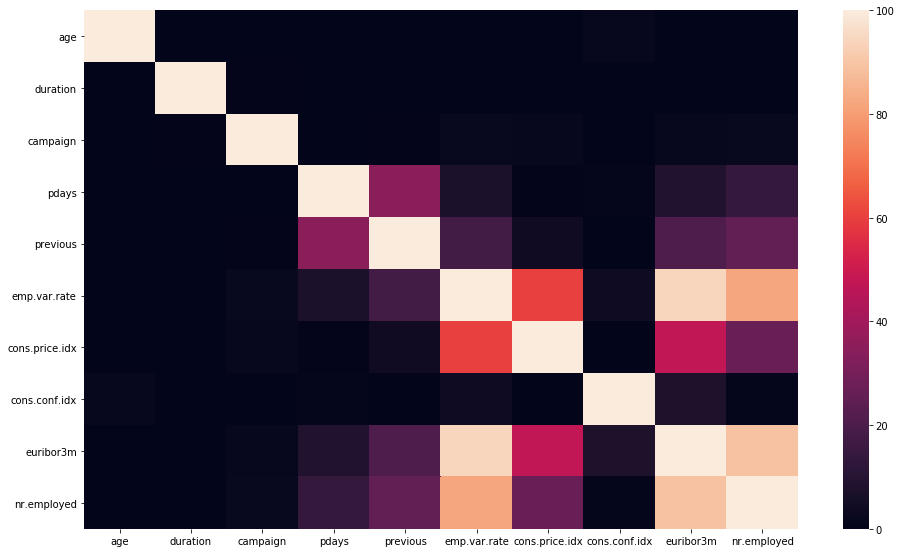

In [12]:
correlation_matrix = df[numeric_variables].corr()
explanability_matrix = correlation_matrix.swifter.apply(lambda x: x ** 2) * 100

plt.rcParams['figure.figsize'] = 16, 9
plt.subplots_adjust(left = 0.125, bottom = 0.1, right = 0.9, top = 0.9, wspace = 0.9, hspace = 0.9)

sns.heatmap(explanability_matrix, xticklabels = numeric_variables, yticklabels = numeric_variables)
plt.show()

***Observations from the above heatmap between numeric variables***

- Age, Previous duration of campaign contact, and the number of campaigns when a client was contacted do not explain any variance of the other variables
- The number of employees a client has had quaterly strongly correlates with and explains a considerable amount of variability for quaterly employment variability rate, euribor 3 month rate and the consumer price index
- Quarterly Consumer Confidence doesn't correlate with any other variable.

<br>

***Aiming for the parsimonious model based on numeric variables only***

A parsimonious model is essentially a result of Occam's Razor. The principle is to obtain a model that has the lowest number of predictor variables with the maximum predictive power for the response variable. Having analyzed the heatmap, I decided to remove the following variables because they are explainable by more than 50% by other variables.

- `euribor3m`
- `emp.var.rate`

#### Explanability heatmap between numeric variables and the type of job the client has

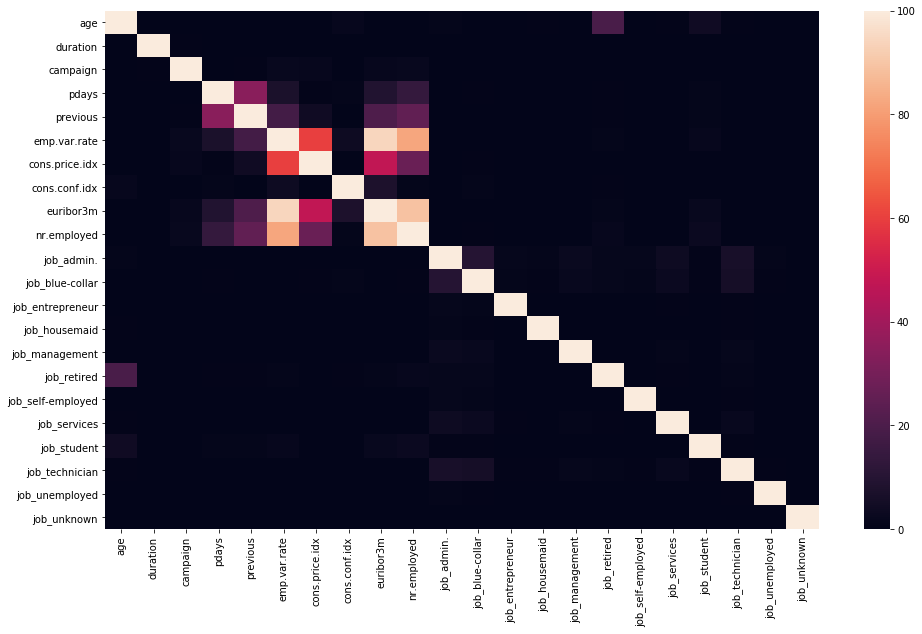

In [13]:
temp = pd.get_dummies(data = df.drop("y", axis = 1, inplace = False), columns = ["job"])
correlation_matrix = temp.corr()
explanability_matrix = correlation_matrix.swifter.apply(lambda x: x ** 2) * 100

plt.rcParams['figure.figsize'] = 16, 9
plt.subplots_adjust(left = 0.125, bottom = 0.1, right = 0.9, top = 0.9, wspace = 0.9, hspace = 0.9)

sns.heatmap(explanability_matrix)
plt.show()

***Observations from the above heatmap between numeric variables and the job kind the client has***

- There's none. No variable can be explained by the specific kind of job a client has.

<br>

#### Explanability heatmap between numeric variables and the marial status of the client

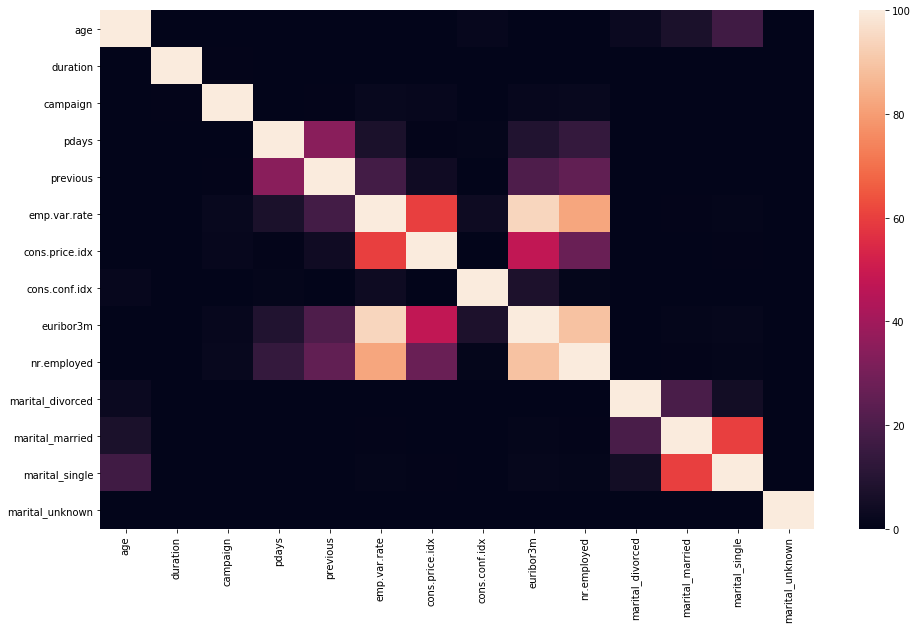

In [14]:
temp = pd.get_dummies(data = df.drop("y", axis = 1, inplace = False), columns = ["marital"])
correlation_matrix = temp.corr()
explanability_matrix = correlation_matrix.swifter.apply(lambda x: x ** 2) * 100

plt.rcParams['figure.figsize'] = 16, 9
plt.subplots_adjust(left = 0.125, bottom = 0.1, right = 0.9, top = 0.9, wspace = 0.9, hspace = 0.9)

sns.heatmap(explanability_matrix)
plt.show()

***Observations from the above heatmap between numeric variables and the the client's martial status***

- There's none. No variable can be explained by the client's maritial status

<br>

#### Explanability heatmap between numeric variables and the education qualification of the client

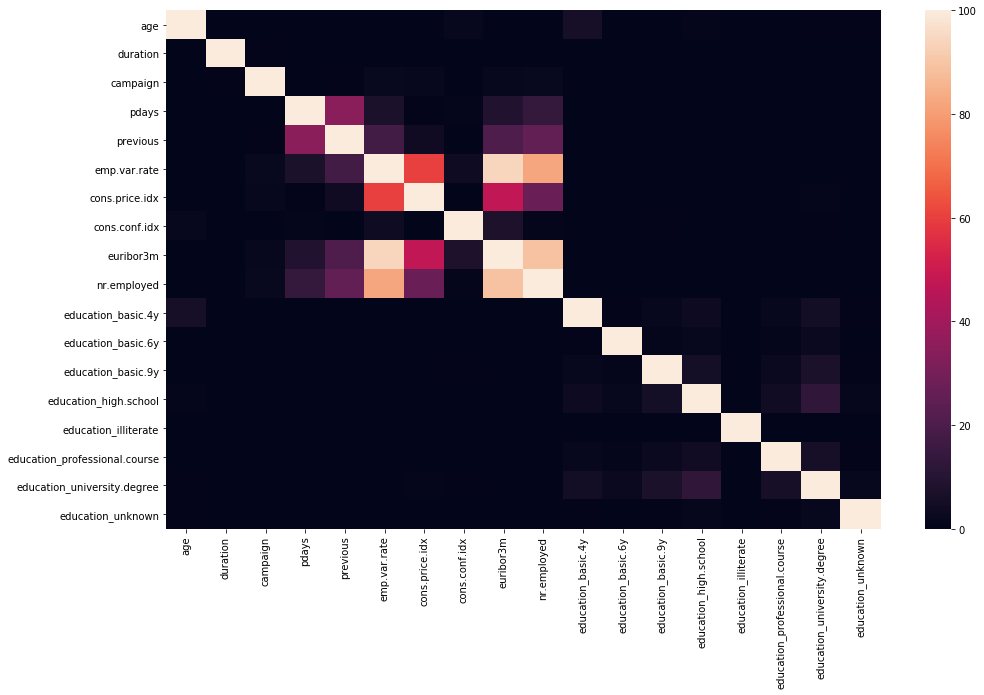

In [15]:
temp = pd.get_dummies(data = df.drop("y", axis = 1, inplace = False), columns = ["education"])
correlation_matrix = temp.corr()
explanability_matrix = correlation_matrix.swifter.apply(lambda x: x ** 2) * 100

plt.rcParams['figure.figsize'] = 16, 9
plt.subplots_adjust(left = 0.125, bottom = 0.1, right = 0.9, top = 0.9, wspace = 0.9, hspace = 0.9)

sns.heatmap(explanability_matrix)
plt.show()

***Observations from the above heatmap between numeric variables and the the client's education qualifiation***

- There's none. No variable can be explained by the client's education qualification

<br>

#### Explanability heatmap between numeric variables and the default status of the client's credit card

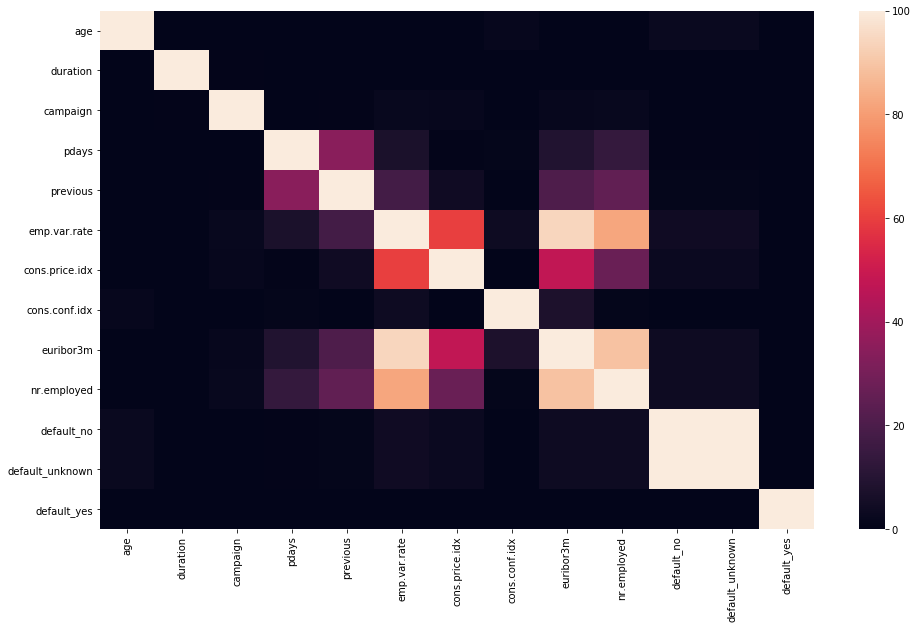

In [16]:
temp = pd.get_dummies(data = df.drop("y", axis = 1, inplace = False), columns = ["default"])
correlation_matrix = temp.corr()
explanability_matrix = correlation_matrix.swifter.apply(lambda x: x ** 2) * 100

plt.rcParams['figure.figsize'] = 16, 9
plt.subplots_adjust(left = 0.125, bottom = 0.1, right = 0.9, top = 0.9, wspace = 0.9, hspace = 0.9)

sns.heatmap(explanability_matrix)
plt.show()

***Observations from the above heatmap between numeric variables and the the client's credit card default status***

- There's none. No variable can be explained by the client's credit card default status

<br>

#### Explanability heatmap between numeric variables and the default status of the client's loan statuses

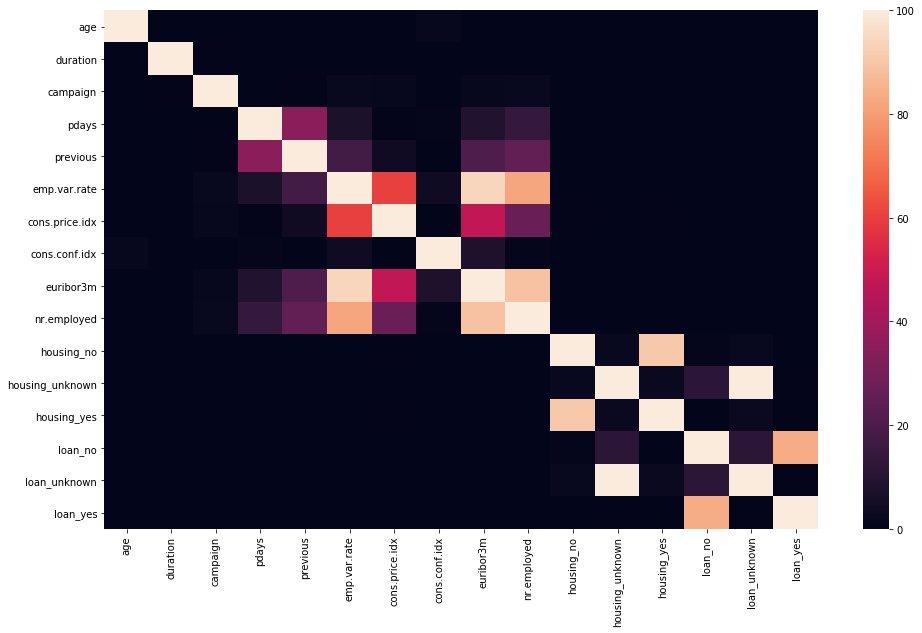

In [17]:
temp = pd.get_dummies(data = df.drop("y", axis = 1, inplace = False), columns = ["housing", "loan"])
correlation_matrix = temp.corr()
explanability_matrix = correlation_matrix.swifter.apply(lambda x: x ** 2) * 100

plt.rcParams['figure.figsize'] = 16, 9
plt.subplots_adjust(left = 0.125, bottom = 0.1, right = 0.9, top = 0.9, wspace = 0.9, hspace = 0.9)

sns.heatmap(explanability_matrix)
plt.show()

***Observations from the above heatmap between numeric variables and the the client's loan statuses***

- If we are uncertain about the client's housing loan status, so are we about his/her personal loan status and vice versa



<br>

***Aiming for the parsimonious model***

I decided to remove the following variable because they are explainable by more than 50% by other variables.

- `housing_unknown`

### Removing dependencies

In [18]:
df_encoded = pd.get_dummies(data = df, columns = categorical_variables)
df_encoded.drop(["housing_unknown", "euribor3m", "emp.var.rate"], axis = 1, inplace = True)
df_encoded.head()

,age,duration,campaign,pdays,previous,cons.price.idx,cons.conf.idx,nr.employed,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y_no,y_yes
0,56,261,1,999,0,93.994,-36.4,5191.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
1,57,149,1,999,0,93.994,-36.4,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1
2,37,226,1,999,0,93.994,-36.4,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
3,40,151,1,999,0,93.994,-36.4,5191.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
4,56,307,1,999,0,93.994,-36.4,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0


In [19]:
df_encoded.columns

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'cons.price.idx',
       'cons.conf.idx', 'nr.employed', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married',
       'marital_single', 'marital_unknown', 'education_basic.4y',
       'education_basic.6y', 'education_basic.9y', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_no',
       'default_unknown', 'default_yes', 'housing_no', 'housing_yes',
       'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'day_of_week_fri', 'day_of_week

<br>
Ought to remove the target variable $y$ because I don't want to be a part of the dataset but an independent vector

In [20]:
df_encoded.shape

(41188, 62)

In [0]:
y = (abs(1 - df_encoded["y_no"]) | df_encoded["y_yes"]).values
y = np.array(y, dtype = np.int32)

In [0]:
df_encoded.drop(["y_no", "y_yes"], axis = 1, inplace = True)

In [23]:
y.shape, df_encoded.shape

((41188,), (41188, 60))

## Preprocessing the dataset for training, testing and validation

### Min-Max Feature Scaling

I will perform min-max feature scaling for every numeric variable in `df_encoded` as the main preprocessing step

In [24]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_encoded_scaled = scaler.fit_transform(df_encoded)
df_encoded.shape, df_encoded_scaled.shape

((41188, 60), (41188, 60))

### Train-Validate-Test split

In [0]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df_encoded_scaled, y, test_size = 0.2, random_state = 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.125, random_state = 1)

In [26]:
x_train.shape, x_val.shape, x_test.shape

((28831, 60), (4119, 60), (8238, 60))

In [27]:
y_train.shape, y_val.shape, y_test.shape

((28831,), (4119,), (8238,))

## Dumping records in `TFRecord` files

### Initializing a dictionary of necessary hyperparameters

In [0]:
from collections import defaultdict
FLAGS = defaultdict(lambda: -1)

FLAGS["epochs"] = 50
FLAGS["number_of_features"] = x_train.shape[1]
FLAGS["total_number_of_observations"] = x_train.shape[0]
FLAGS["num_parallel_calls"] = 3
FLAGS["shuffle_buffer"] = 256
FLAGS["batch_size_train"] = 256
FLAGS["prefetch_buffer"] = 3
FLAGS["learning_rate"] = 1e-3

### Creating tfRecord dump directories for the training, validation and testing datasets

In [0]:
!mkdir -p "train_tfrecords"
!mkdir -p "test_tfrecords"
!mkdir -p "val_tfrecords"

In [0]:
train_dump = "./train_tfrecords/"
test_dump = "./test_tfrecords/"
val_dump = "./val_tfrecords/"

### Defining a function to dump a batched subset of a dataset

- `x_subset` = subset (sliced) `numpy.ndarray`
 - _`x_subset` is expected to be a matrix in the context of this project_
 
- `y_subset` = subset (sliced) `numpy.ndarray`
 - _`y_subset` is expected to be a vector with the same number of rows as that of `x_subset`_
 
- `writer` =  An instance of `tf.python_io.TFRecordWriter` which has been initialized with a dump directory path. 

<br>

***How does the dumping work?***

- Initialize a writer object `writer`
- Convert all your dump data to lists (because the dumper only works with lists)
 - Since our numpy array is essentially a form of nested list, I need to extract each row(sub-list) from the nested list and then pass it to `tf.train.Feature`
- Create a `tf.train.Feature` object out of each wrapped-up data variable seperately. Use the appropiate argument name: `float_list`, `int32_list`, `int64_list`
- Create a native `dict` out of the `tf.train.Feature` instances by associating a key with each of them. This `dict` will now serve as a schema of storage and retrieval for each feature-label pair.
- Wrap the `dict` in a `tf.train.Example`. In essence, each row in the dataset is now a single `Example` object to be fed into a Tensorflow Data-Flow Graph.


***Why do we do this?***

- Need for speed
- Setting a highly-parallelized, optimized and efficient pipeline for flow of data

In [0]:
def dump_into_tf_record_file(x_subset, y_subset, writer, verbose = True):
    m, n = x_subset.shape
    data_list = x_subset.tolist()
    label_list = y_subset.tolist()
    
    if verbose:
        print("Shape of data after list transformation = ", len(data_list), ",", len(data_list[0]))
        print("label after list transformation = ", label_list)
    
    flagRaised = True
    for data, label in zip(data_list, label_list):
        if flagRaised:
            print("Shape of a single example: data = ", len(data), "(", type(data), ") label = ", label, "(", type(label), ")")
            flagRaised = False
        data = tf.train.Feature(float_list = tf.train.FloatList(value = data))
        label = tf.train.Feature(float_list = tf.train.FloatList(value = [label]))
        feature_dict = {"features":data, "label":label}
        feature_dict = tf.train.Features(feature = feature_dict)
        example = tf.train.Example(features = feature_dict)
        writer.write(example.SerializeToString())

### Defining a function to dump a dataset as tfRecord files in a specified directory

- `dataset` = the `numpy.ndarray` of feature matrix to be dumped
- `labels` = the `numpy.ndarray` vector of output/target/response variable for `dataset`
- `dump_directory` = path to the local directory where the tfRecord files will be dumped
- `batch_size` = how many rows of `dataset` and `labels` will be there in each tfRecord file

In [0]:
def dump_dataset_into_tf_records(dataset, labels, dump_directory, batch_size):
    m, n = dataset.shape
    number_of_files = m//batch_size
    dataset = dataset[:number_of_files * batch_size, :]
    for i in range(number_of_files):
        j = i * batch_size
        k = j + batch_size
        x_subset = dataset[j:k, :]
        y_subset = labels[j:k]
        record_file_name = dump_directory  + "Batch_" + str(i) + ".tfrecord"
        writer = tf.python_io.TFRecordWriter(record_file_name)
        print("\nDump in progress - File %i" % i)
        print("----------------------------------")
        print("\n(Before Dump)")
        print('x_subset.shape = ', x_subset.shape)
        print('y_subset.shape = ', y_subset.shape)
        print("\n(During Dump)")
        dump_into_tf_record_file(x_subset, y_subset, writer)
        writer.close()
        x_subset = None
        y_subset = None
        print("\n(Dump completed)\n")

### Dump `x_train` and `y_train` at `./train_tfrecords`

In [33]:
!rm -rf $train_dump/*
dump_dataset_into_tf_records(x_train, y_train, train_dump, 300)


Dump in progress - File 0
----------------------------------

(Before Dump)
x_subset.shape =  (300, 60)
y_subset.shape =  (300,)

(During Dump)
Shape of data after list transformation =  300 , 60
label after list transformation =  [0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Dump `x_val` and `y_val` at `./val_tfrecords`

In [34]:
!rm -rf $val_dump/*
dump_dataset_into_tf_records(x_val, y_val, val_dump, 300)


Dump in progress - File 0
----------------------------------

(Before Dump)
x_subset.shape =  (300, 60)
y_subset.shape =  (300,)

(During Dump)
Shape of data after list transformation =  300 , 60
label after list transformation =  [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,

### Dump `x_test` and `y_test` at `./test_tfrecords`

In [35]:
!rm -rf $test_dump/*
dump_dataset_into_tf_records(x_test, y_test, test_dump, 300)


Dump in progress - File 0
----------------------------------

(Before Dump)
x_subset.shape =  (300, 60)
y_subset.shape =  (300,)

(During Dump)
Shape of data after list transformation =  300 , 60
label after list transformation =  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,

## Creating Input Pipeline using tfRecords

### Defining a function to retrive the tfRecord files from a directory in an efficient sequential manner

- Create an object of `tf.data.Dataset` using its `tf.data.Dataset.list_files` method by passing the dump directory path
- I chose to parallelize the batch dataset retrieval and processing to be fed into the Data Flow graph using `tf.contrib.data.map_and_batch`by setting `num_parallel_calls` argument
- I also chose to shuffle the dataset during the retrieval pipeline
- To further enhance the performance of the training process, I used `tf.train.Dataset.prefetch` method to set how many `tf.train.Example` objects will be fetched before it's turn has arrived to be fed into the Data-Flow graph

In [0]:
import os

def get_dataset(directory):
    
    record_file_names = [directory + file_name for file_name in os.listdir(directory)]
    dataset = tf.data.TFRecordDataset(record_file_names)
    #record_file_names = tf.data.Dataset.list_files(record_file_names)
    dataset = dataset.map(parse_record)
    #dataset = record_file_names.apply(tf.contrib.data.parallel_interleave(tf.data.TFRecordDataset, cycle_length = 2))
    dataset = dataset.shuffle(buffer_size = FLAGS["shuffle_buffer"])
    dataset = dataset.batch(FLAGS["batch_size_train"])
    #dataset = dataset.apply(tf.contrib.data.map_and_batch(map_func = parse_record, batch_size = FLAGS["batch_size_train"], num_parallel_calls = FLAGS["num_parallel_calls"]))
    dataset = dataset.prefetch(buffer_size = FLAGS["prefetch_buffer"])    
    return(dataset)

### Defining a function to parse each `tf.train.Example` from the tfRecord files

In [0]:
def parse_record(serialized_record):
    features_dict = {"features":tf.FixedLenFeature([FLAGS["number_of_features"]], tf.float32), "label":tf.FixedLenFeature([1], tf.float32)}
    parsed = tf.parse_single_example(serialized = serialized_record, features = features_dict)

    data = parsed["features"]
    label = parsed["label"]
    
    data = tf.cast(data, tf.float32)
    label = tf.cast(label, tf.int32)
    
    return((data, label))

## Designing the DataFlow Graph and executing a session

### Logical structure of the Data Flow Graph as an user-defined Python Class object

***Base Model Class***

- this class will define the weight matrices, the bias vectors and their corresponding initializers
- this class will most importantly define the feed-forward architecture of the fully-connected neural network
- I took inspiration from François Chollet's `keras` framework which serves as a high-level wrapper API for Tensorflow (as well as other backends) and decided to write this class as a wrapper for creating custom Data Flow Graphs in Tensorflow

<br>

- `FCNN` will be my base model class name
- the class will be initalizer with defining the weight and bias tensor initializers
- the class will have a method `add_weight_matrix` which will add a weight matrix to the FCNN. The order in which the method is called to add the weight matrix determines the hidden layer to which the weight matrix will be associated.
- similarly, the class have a method `add_bias_vector`
- the most important method of the class will be `forward_propagation` which creates the Data Flow graph using the defined weight and bias tensors and returns the graph generated till the last hidden layer and the classification output generated

In [0]:
class FCNN:
    def __init__(self, 
                 weight_initializer = tf.random_normal_initializer(mean = 0.0, stddev = 0.25),
                 bias_initializer = tf.zeros_initializer()):
        self.weight_initializer = weight_initializer
        self.bias_initializer = bias_initializer
        self.weights = []
        self.biases = []
    def add_weight_matrix(self, shape, scope_name = "WEIGHTS", dtype = tf.float32):
        with tf.name_scope(scope_name):
            i = len(self.weights)
            self.weights.append(tf.get_variable(name = "W" + str(i),
                                                shape = shape, 
                                                dtype = dtype,
                                                initializer = self.weight_initializer))
    def add_bias_vector(self, shape, scope_name = "BIASES", dtype = tf.float32):
        with tf.name_scope(scope_name):
            i = len(self.biases)
            self.biases.append(tf.get_variable(name = "B" + str(i),
                                               shape = shape,
                                               dtype = dtype,
                                               initializer = self.bias_initializer))
    def forward_propagation(self, x_subset, output_activation_function = tf.nn.softmax):
        with tf.name_scope("FEED_FORWARD_PROPAGATION"):
            x = x_subset
            for i in range(len(self.biases)):
                z = tf.matmul(x, self.weights[i]) + self.biases[i]
                h = tf.nn.relu(z)
                x = h
            h = tf.matmul(x, self.weights[-1])
            yhat = output_activation_function(h)
            return(h, yhat)

***Train Model Class***

- this class will be a child of `FCNN`
- this class will contain methods to define the loss function and  compute the loss incured by the Neural Network (FCNN instance)
- the most important method of this child class will be to define the back propagation of loss gradients

In [0]:
class myModel(FCNN):
    def __init__(self, batch_size, learning_rate):
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        super(myModel, self).__init__()
    def compute_loss_incured(self, y_subset, yhat, loss_function = tf.nn.sparse_softmax_cross_entropy_with_logits, scope_name = "L", add_penalty = True):
        with tf.name_scope(scope_name):
            y_subset = tf.reshape(y_subset, [FLAGS["batch_size_train"]])
            cross_entropy = loss_function(labels = y_subset, 
                                          logits = yhat, 
                                          name = "CROSS_ENTROPY_LOSS")
            loss = tf.reduce_mean(cross_entropy, name = "AVERAGE_CROSS_ENTROPY_LOSS")
            
            if add_penalty:
                l2_loss = tf.add_n([tf.nn.l2_loss(T) for T in tf.trainable_variables()])
                loss = loss + self.learning_rate * l2_loss
        
        return(loss)
    def compute_naive_accuracy(self, x_subset, y_subset, scope_name = "NAIVE_ACCURACY"):
        with tf.name_scope(scope_name):
            _, yhat = self.forward_propagation(x_subset)
            y_subset = tf.cast(y_subset, tf.int32)
            yhat_index = tf.argmax(yhat, axis = 1, output_type = tf.int32)
            are_yhat_and_y_equal = tf.equal(yhat_index, y_subset)
            are_yhat_and_y_equal = tf.cast(are_yhat_and_y_equal, tf.float32)
            accuracy = tf.reduce_mean(are_yhat_and_y_equal)
        
        return(accuracy)
    def backward_propagation(self, loss):
        with tf.name_scope("BACKWARD_PROPAGATION"):
            trainable_variables = tf.trainable_variables()
            gradients = tf.gradients(loss, trainable_variables, name = "dL")
            optimizer = tf.train.AdamOptimizer(self.learning_rate, name = "Min_dL")
            update_operation = optimizer.apply_gradients(zip(gradients, trainable_variables), name = "dL_update")
        
        return(update_operation)

***Performance Evaluation Metrics***

- Recall
- Precision
- F1 score
- AUC

In [0]:
from sklearn.metrics import confusion_matrix, roc_auc_score

def evaluate_model(y_subset, yhat, pos_label_scores):    
    tn, fp, fn, tp = confusion_matrix(y_subset, yhat).ravel() 
    
    precision = tp/(tp+fp)
    recall = tp/(tp + fn)
    f1 = (2 * precision * recall)/(precision + recall)
    auc = roc_auc_score(y_subset, pos_label_scores)
    
    print('Precision: %.5f: '%precision)
    print('Recall: %.5f: '%recall)
    print('F1 score: %.5f: '%f1)
    print('AUC: %f'%auc)

### Defining Session Protocols

In [0]:
config = tf.ConfigProto(log_device_placement = True)
config.gpu_options.allow_growth = True

### Create  the DataFlow Graph

In [63]:
number_of_batches = x_train.shape[0]//FLAGS["batch_size_train"]

G = tf.Graph()

with G.as_default():
    with tf.name_scope("INPUT_PIPELINE"):
        train = get_dataset(train_dump)
        test = get_dataset(test_dump)
        validation = get_dataset(val_dump)
        
        train_iterator = train.make_initializable_iterator()
        test_iterator = test.make_initializable_iterator()
        val_iterator = validation.make_initializable_iterator()
        
        x_train_subset, y_train_subset = train_iterator.get_next()
        x_val_subset, y_val_subset = val_iterator.get_next()
        x_test_subset, y_test_subset = test_iterator.get_next()
        
        x_train_subset_copy = (x_train_subset)
        y_train_subset_copy = (y_train_subset)
        
        print("Shape of INPUT FEATURES = \t\t\t\t", tf.shape(x_train_subset_copy))
        print("Shape of GROUND TRUTH LABEL = \t\t\t\t", tf.shape(y_train_subset_copy))
    
    model = myModel(FLAGS["batch_size_train"], FLAGS["learning_rate"])
    
    # first hidden layer
    model.add_weight_matrix(shape = [FLAGS["number_of_features"], 128])
    model.add_bias_vector(shape = [128])
    
    # second hidden layer
    model.add_weight_matrix(shape = [128, 256])
    model.add_bias_vector(shape = [256])
    
    # third hidden layer
    model.add_weight_matrix(shape = [256, 128])
    model.add_bias_vector(shape = [128])
    
    # fourth hidden layer
    model.add_weight_matrix(shape = [128, 64])
    model.add_bias_vector(shape = [64])
    
    # fifth hidden layer
    model.add_weight_matrix(shape = [64, 2])
    
    h, _ = model.forward_propagation(x_train_subset_copy)
    print("After forward propagation, shape of h (logits) = \t", tf.shape(h))
    
    loss = model.compute_loss_incured(y_train_subset_copy, h)    
    update_operation = model.backward_propagation(loss)
    
    train_accuracy = model.compute_naive_accuracy(x_train_subset_copy, y_train_subset_copy)
    validation_accuracy = model.compute_naive_accuracy(x_val_subset, y_val_subset)
    _, yhat_predictions = model.forward_propagation(x_test_subset)

Shape of INPUT FEATURES = 				 Tensor("INPUT_PIPELINE/Shape:0", shape=(2,), dtype=int32)
Shape of GROUND TRUTH LABEL = 				 Tensor("INPUT_PIPELINE/Shape_1:0", shape=(2,), dtype=int32)
After forward propagation, shape of h (logits) = 	 Tensor("Shape:0", shape=(2,), dtype=int32)


### Execute a session

In [66]:
tf.reset_default_graph()

loss_history = []
train_accuracy_history = []
validation_accuracy_history = []

with tf.Session(graph = G, config = config) as session:
    session.run(tf.global_variables_initializer())
    print("(Training)\n\n")
    for i in range(FLAGS["epochs"]):
        session.run(train_iterator.initializer)
        session.run(val_iterator.initializer)
        
        temp_loss = 0
        temp_accuracy = 0
        
        for j in range(number_of_batches):

            _, L, A = session.run((update_operation, loss, train_accuracy))
            temp_loss = temp_loss + L
            temp_accuracy = temp_accuracy + A
        
        temp_validation_accuracy = session.run(validation_accuracy)
        temp_loss = temp_loss/number_of_batches
        temp_accuracy = temp_accuracy/number_of_batches
        
        loss_history.append(temp_loss)
        train_accuracy_history.append(temp_accuracy)
        validation_accuracy_history.append(temp_validation_accuracy)
        
        print("Epoch %i:\tTA = %0.04f\tTL = %0.04f\tVA = %0.04f" % ((i + 1), temp_accuracy, temp_loss, temp_validation_accuracy))
   
    print("\n\n(Evaluation)\n\n")
    session.run(test_iterator.initializer)
    scores, y_test = session.run((yhat_predictions, y_test_subset))
    y_predictions = np.argmax(scores, axis = 1)
    pos_label_scores = scores[:, 1]
    evaluate_model(y_test, y_predictions, pos_label_scores)

(Training)


Epoch 1:	TA = 0.8217	TL = 3.1760	VA = 0.8723
Epoch 2:	TA = 0.8383	TL = 2.4829	VA = 0.8817
Epoch 3:	TA = 0.8388	TL = 2.2253	VA = 0.8637
Epoch 4:	TA = 0.8378	TL = 2.0153	VA = 0.8872
Epoch 5:	TA = 0.8353	TL = 1.8458	VA = 0.8650
Epoch 6:	TA = 0.8321	TL = 1.6992	VA = 0.8918
Epoch 7:	TA = 0.8299	TL = 1.5706	VA = 0.8580
Epoch 8:	TA = 0.8269	TL = 1.4634	VA = 0.8992
Epoch 9:	TA = 0.8267	TL = 1.3657	VA = 0.8918
Epoch 10:	TA = 0.8256	TL = 1.2816	VA = 0.8889
Epoch 11:	TA = 0.8247	TL = 1.2024	VA = 0.8798
Epoch 12:	TA = 0.8237	TL = 1.1326	VA = 0.8984
Epoch 13:	TA = 0.8227	TL = 1.0679	VA = 0.8741
Epoch 14:	TA = 0.8220	TL = 1.0106	VA = 0.8886
Epoch 15:	TA = 0.8209	TL = 0.9543	VA = 0.8735
Epoch 16:	TA = 0.8209	TL = 0.9056	VA = 0.8882
Epoch 17:	TA = 0.8198	TL = 0.8609	VA = 0.8898
Epoch 18:	TA = 0.8192	TL = 0.8192	VA = 0.9021
Epoch 19:	TA = 0.8191	TL = 0.7781	VA = 0.8741
Epoch 20:	TA = 0.8182	TL = 0.7421	VA = 0.8752
Epoch 21:	TA = 0.8176	TL = 0.7097	VA = 0.8589
Epoch 22:	TA = 0.8174	TL = 0.6

## Visualize KPIs

### Training Accuracy, Loss and Validation Accuracy

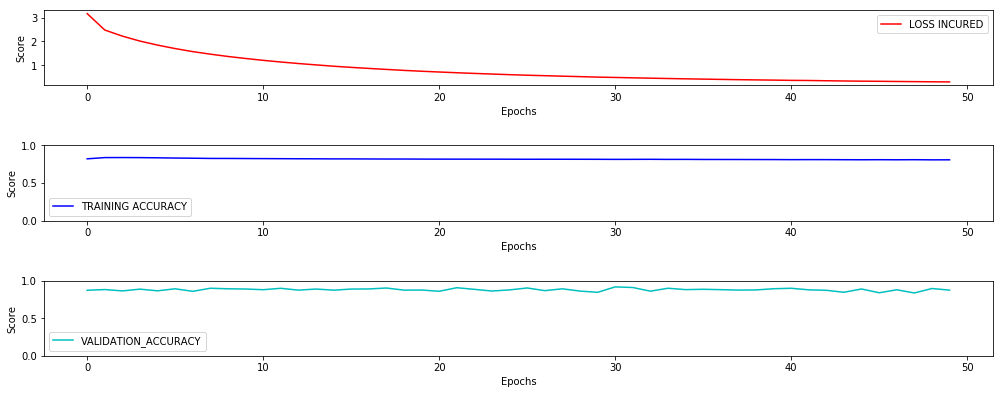

In [67]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = 17, 6
plt.subplots_adjust(left = 0.125, bottom = 0.1, right = 0.9, top = 0.9, wspace = 0.8, hspace = 0.8)

t = np.arange(len(train_accuracy_history))

plt.subplot(3, 1, 1)
plt.plot(t, loss_history, "r", label = "LOSS INCURED")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t, train_accuracy_history, "b", label = "TRAINING ACCURACY")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.ylim([0, 1])
plt.legend()

t = np.arange(len(validation_accuracy_history))

plt.subplot(3, 1, 3)
plt.plot(t, validation_accuracy_history, "c", label = "VALIDATION_ACCURACY")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.ylim([0, 1])
plt.legend()

plt.show()

### Performance in terms of recall, precision and $F(1)$

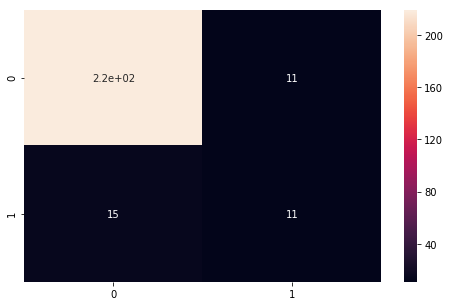

In [92]:
Y = np.squeeze(y_test).tolist()
YHAT = y_predictions.tolist()
CM = confusion_matrix(Y, YHAT, labels = [0, 1])
plt.rcParams['figure.figsize'] = 8, 5
sns.heatmap(CM, annot = True)
plt.show()

In [96]:
sum(np.array(Y) & np.array(YHAT)), sum(~np.array(Y, dtype = bool) & ~np.array(YHAT, dtype = bool))

(11, 219)

In [97]:
sum(np.array(Y)), sum(~np.array(Y, dtype = bool))

(26, 230)